<a href="https://colab.research.google.com/github/babsyco/C19_cases_deaths_vaccinations/blob/main/vaccine_rollout1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv



In [ ]:
###########
# IMPORTS #
###########
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os

In [ ]:
######################
# IMPORT RAW DATASET #
######################
# (Raw dataset summary displayed at end of notebook)
OWID_data_url = ''
OWID_dataRaw_df = ''
OWID_dataRaw_df_dimensions = ''
OWID_dataRaw_locations = ''
OWID_latest_date = ''

OWID_data_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
OWID_dataRaw_df = pd.read_csv(OWID_data_url, error_bad_lines=False)

# RAW DATA PARAMETERS
OWID_dataRaw_df_dimensions = OWID_dataRaw_df.shape
OWID_dataRaw_locations = OWID_dataRaw_df.location.unique()
OWID_dataRaw_df['date'] = pd.to_datetime(OWID_dataRaw_df['date'])
OWID_dates = OWID_dataRaw_df['date'].to_list()
OWID_latest_date = OWID_dataRaw_df['date'].to_list()[-1]

In [ ]:
########################
# PRE-PROCESS RAW DATA #
########################
min_population = 1000000

OWID_preProcessed_data_df = OWID_dataRaw_df.copy()
# CONVERT 'date' COLUMN TO DATETIME DATA TYPE
OWID_preProcessed_data_df['date'] = pd.to_datetime(OWID_preProcessed_data_df['date'])
# REMOVE SMALL LOCATIONS
OWID_preProcessed_data_df = OWID_preProcessed_data_df[OWID_preProcessed_data_df.population >= min_population]
# SET 'location' AS ROW INDEX
OWID_preProcessed_data_df.set_index('location', inplace=True)
#RE-SCALE 'total_vaccinations_per_hundred' AND 'people_fully_vaccinated_per_hundred' TO PER MILLION
OWID_preProcessed_data_df['total_vaccinations_per_hundred'] *= 10000
OWID_preProcessed_data_df['people_fully_vaccinated_per_hundred'] *= 10000
OWID_preProcessed_data_df.rename(columns = {"total_vaccinations_per_hundred":"total_vaccinations_per_million",
                                            "people_fully_vaccinated_per_hundred":"people_fully_vaccinated_per_million"}, inplace=True)

In [ ]:
################################
# CREATE DATASETS TO BE USED #
################################
perCapita_daily_columns = []
perCapita_cumulative_columns = []
OWID_perCapita_daily_df = ''
OWID_perCapita_cumulative_df = ''

perCapita_daily_columns = ["date","new_cases_smoothed_per_million", "new_deaths_smoothed_per_million",
                           "new_vaccinations_smoothed_per_million"]
perCapita_cumulative_columns = ["date", "total_cases_per_million", "total_deaths_per_million",
                                "total_vaccinations_per_million", "people_fully_vaccinated_per_million"]

# CREATE DATAFRAMES
OWID_perCapita_daily_df = OWID_preProcessed_data_df[perCapita_daily_columns]
OWID_perCapita_cumulative_df = OWID_preProcessed_data_df[perCapita_cumulative_columns]

In [ ]:
##############
# SAVE PLOTS #
##############

if (input("Save/download plots? y/n: ").lower()[0] == 'y'):
  save_files = True
  print("\nPlots will be saved/downloaded.")
else:
  save_files = False
  print("Plots will not be saved/downloaded.")



Save/download plots? y/n: n
Plots will not be saved/downloaded.


KeyboardInterrupt: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

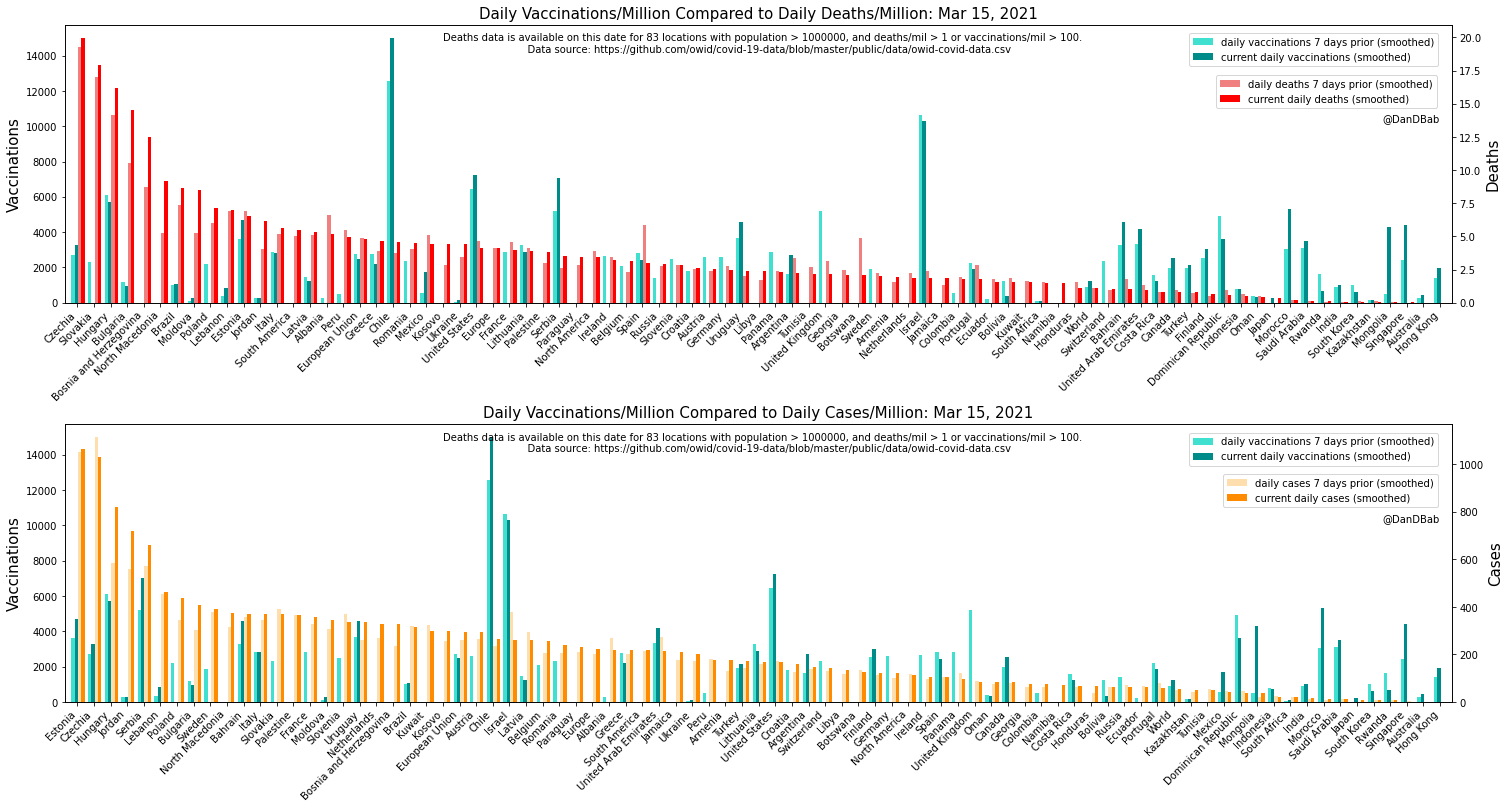

In [ ]:
#########################
# PER CAPITA DAILY DATA #
#########################
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
bar_transparency = 1
date_offset = 0
current_date = OWID_dates[-1+date_offset]
past_date = OWID_dates[-1*(num_days_back-date_offset)]
daily_deaths_threshold = 1 # include locations with more than this per million
daily_vax_threshold = 100

# Remove locations below daily deaths and vaccinations thresholds
OWID_perCapita_daily_filtered_df = OWID_perCapita_daily_df.query('new_deaths_smoothed_per_million > %d or new_vaccinations_smoothed_per_million > %d' %
                                                                 (daily_deaths_threshold, daily_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = OWID_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = OWID_perCapita_daily_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths/mil > %d or vaccinations/mil > %d.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv"\
     % (len([i[0] for i in temp_current_df.index]), min_population, daily_deaths_threshold, daily_vax_threshold)

# death/vaccinations (top)
# sort temp datasets by "new_deaths_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_deaths_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top1.set_ylabel('Vaccinations', fontsize=15)
ax_top2.set_ylabel('Deaths', fontsize=15)
ax_top1.set_title("Daily Vaccinations/Million Compared to Daily Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=-1)
ax_top1.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=-1)
ax_top2.bar(x_vals + bar_width*2, temp_past_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=-1)
ax_top2.bar(x_vals + bar_width*3, temp_current_df["new_deaths_smoothed_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=-1)
ax_top1.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_top2.legend(['daily deaths %d days prior (smoothed)'%num_days_back, 'current daily deaths (smoothed)'], loc=[0.83, 0.7])
ax_top1.text(ax_top1.get_xlim()[1]/2, ax_top1.get_ylim()[1]*0.9, inclusion_string, ha='center', fontsize=10)
ax_top1.text(ax_top1.get_xlim()[1]*0.97, ax_top1.get_ylim()[1]*0.65, '@DanDBab', ha='center', fontsize=10)

# cases/vaccinations (bottom)
# sort temp datasets by "new_cases_smoothed_per_million"
temp_current_df = temp_current_df.sort_values("new_cases_smoothed_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom1.set_ylabel('Vaccinations', fontsize=15)
ax_bottom2.set_ylabel('Cases', fontsize=15)
ax_bottom1.set_title("Daily Vaccinations/Million Compared to Daily Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals, temp_past_df["new_vaccinations_smoothed_per_million"], color='turquoise', width=bar_width, zorder=-1)
ax_bottom1.bar(x_vals + bar_width, temp_current_df["new_vaccinations_smoothed_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=-1)
ax_bottom2.bar(x_vals + bar_width*2, temp_past_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='navajowhite', width=bar_width, zorder=-1)
ax_bottom2.bar(x_vals + bar_width*3, temp_current_df["new_cases_smoothed_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width, zorder=-1)
ax_bottom1.legend(['daily vaccinations %d days prior (smoothed)'%num_days_back, 'current daily vaccinations (smoothed)'], loc=[0.81,0.85])
ax_bottom2.legend(['daily cases %d days prior (smoothed)'%num_days_back, 'current daily cases (smoothed)'], loc=[0.835, 0.7])
ax_bottom1.text(ax_top1.get_xlim()[1]/2, ax_top1.get_ylim()[1]*0.9, inclusion_string, ha='center', fontsize=10)
ax_bottom1.text(ax_top1.get_xlim()[1]*0.97, ax_top1.get_ylim()[1]*0.65, '@DanDBab', ha='center', fontsize=10)

# save file
if save_files:
  filename = 'daily vaccine vs deaths per capita'
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

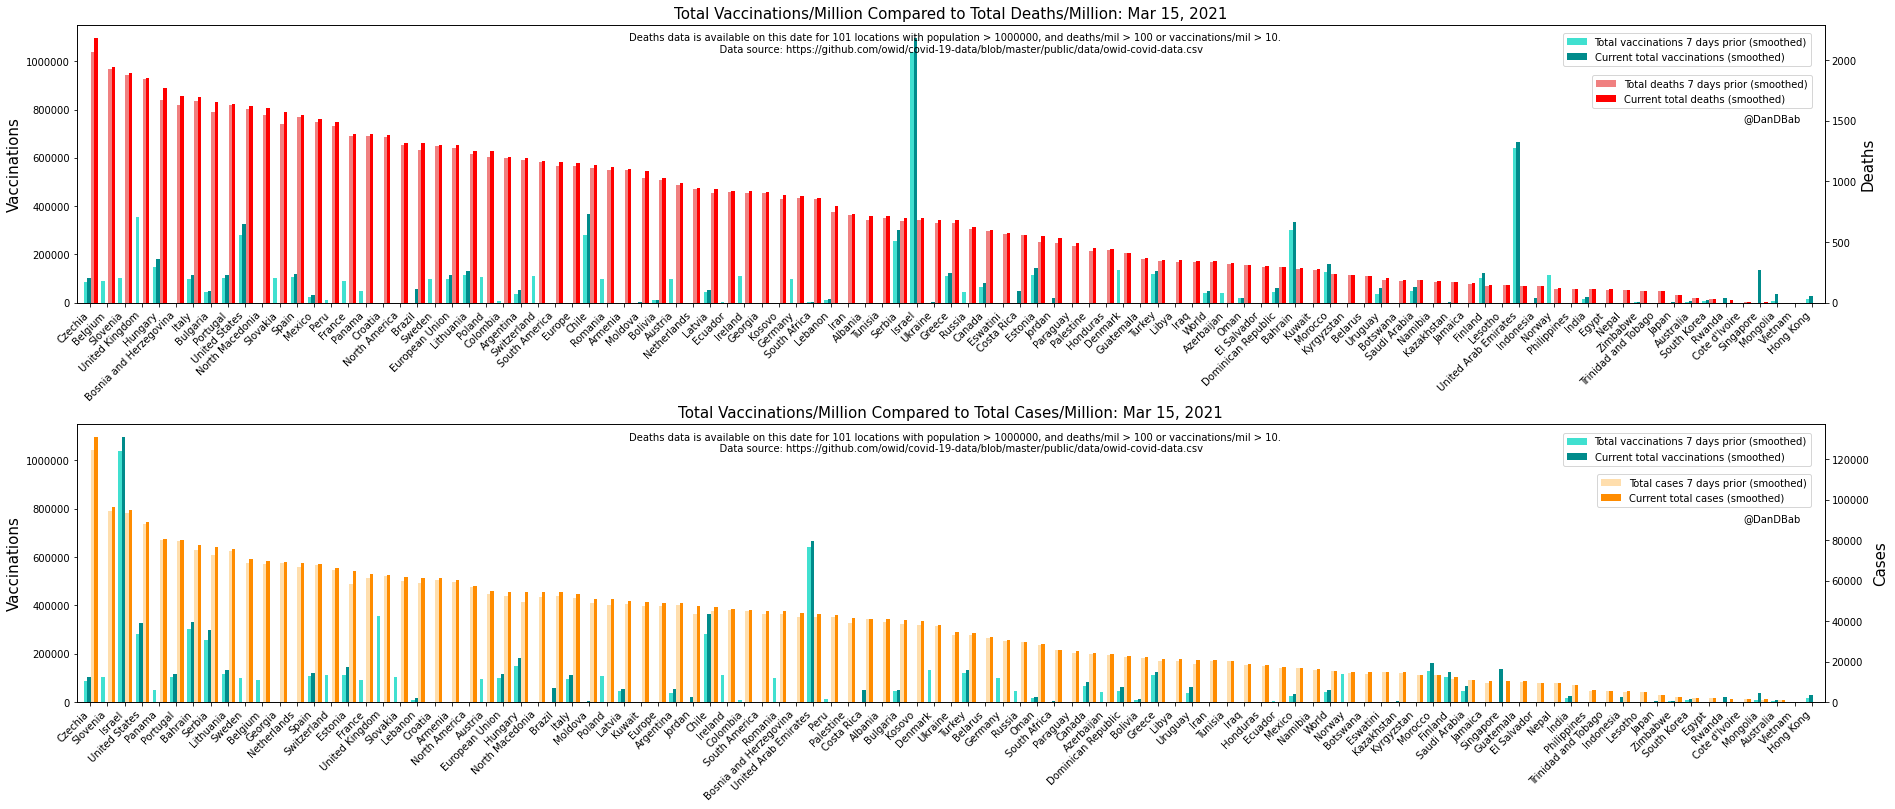

In [ ]:
#########################
# CUMULATIVE DAILY DATA #
#########################
num_days_back = 7
legend_labels = []
x_vals = []
bar_width = 0.2
date_offset = 0
current_date = OWID_dates[-1+date_offset]
past_date = OWID_dates[-1*(num_days_back-date_offset)]
cumulative_deaths_threshold = 100 # include locations with more than this per million
cumulative_vax_threshold = 10

# Remove locations below daily deaths and vaccinations thresholds
OWID_perCapita_cumulative_filtered_df = OWID_perCapita_cumulative_df.query('total_deaths_per_million > %d or total_vaccinations_per_million > %d' %
                                                                 (cumulative_deaths_threshold, cumulative_vax_threshold))
# Temp datasets: extract current and past date rows for each location
temp_current_df = OWID_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == current_date])
temp_past_df = OWID_perCapita_cumulative_filtered_df.sort_values('date').groupby('location').apply(lambda x: x[x['date'] == past_date])

# CREATE PLOTS
x_vals = np.arange(len(temp_current_df.index))
fig, axs = plt.subplots(2, 1, figsize=[int(len(x_vals)/4),10])
axs[0].ticklabel_format(scilimits=[0, 10])
axs[1].ticklabel_format(scilimits=[0, 10])
fig.tight_layout(h_pad=10)
inclusion_string = "Deaths data is available on this date for %d locations with population > %d, and deaths/mil > %d or vaccinations/mil > %d.\n\
    Data source: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv"\
     % (len([i[0] for i in temp_current_df.index]), min_population, cumulative_deaths_threshold, cumulative_vax_threshold)

# death/vaccinations (top)
# sort temp datasets by deaths
temp_current_df = temp_current_df.sort_values("total_deaths_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
# plot
ax_top1 = axs[0]
ax_top2 = ax_top1.twinx()
ax_top1.set_ylabel('Vaccinations', fontsize=15)
ax_top2.set_ylabel('Deaths', fontsize=15)
ax_top1.set_title("Total Vaccinations/Million Compared to Total Deaths/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_top1.set_xticks(x_vals + bar_width*1.3)
ax_top1.set_xlim([-0.5,len(x_vals)])
ax_top1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_top1.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width, zorder=-1)
ax_top1.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width, zorder=-1)
ax_top2.bar(x_vals + bar_width*2, temp_past_df["total_deaths_per_million"], alpha=bar_transparency, color='lightcoral', width=bar_width, zorder=-1)
ax_top2.bar(x_vals + bar_width*3, temp_current_df["total_deaths_per_million"], alpha=bar_transparency, color='red', width=bar_width, zorder=-1)
ax_top1.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_top2.legend(['Total deaths %d days prior (smoothed)'%num_days_back, 'Current total deaths (smoothed)'], loc=[0.867, 0.7])
ax_top1.text(ax_top1.get_xlim()[1]/2, ax_top1.get_ylim()[1]*0.9, inclusion_string, ha='center', fontsize=10)
ax_top1.text(ax_top1.get_xlim()[1]*0.97, ax_top1.get_ylim()[1]*0.65, '@DanDBab', ha='center', fontsize=10)

# cases/vaccinations (bottom)
# sort temp datasets by cases
temp_current_df = temp_current_df.sort_values("total_cases_per_million", ascending=False)
temp_past_df = temp_past_df.reindex(temp_current_df.index)
#plot
ax_bottom1 = axs[1]
ax_bottom2 = ax_bottom1.twinx()
ax_bottom1.set_ylabel('Vaccinations', fontsize=15)
ax_bottom2.set_ylabel('Cases', fontsize=15)
ax_bottom1.set_title("Total Vaccinations/Million Compared to Total Cases/Million: %s" % current_date.strftime('%b %d, %Y'), fontsize=15)
ax_bottom1.set_xticks(x_vals + bar_width*1.3)
ax_bottom1.set_xticklabels([i[0] for i in temp_current_df.index], rotation = 45, ha='right')
ax_bottom1.set_xlim([-0.5,len(x_vals)])
ax_bottom1.bar(x_vals, temp_past_df["total_vaccinations_per_million"], color='turquoise', width=bar_width)
ax_bottom1.bar(x_vals + bar_width, temp_current_df["total_vaccinations_per_million"], alpha=bar_transparency, color='darkcyan', width=bar_width)
ax_bottom2.bar(x_vals + bar_width*2, temp_past_df["total_cases_per_million"], alpha=bar_transparency, color='navajowhite', width=bar_width)
ax_bottom2.bar(x_vals + bar_width*3, temp_current_df["total_cases_per_million"], alpha=bar_transparency, color='darkorange', width=bar_width)
ax_bottom1.legend(['Total vaccinations %d days prior (smoothed)'%num_days_back, 'Current total vaccinations (smoothed)'], loc=[0.85,0.85])
ax_bottom2.legend(['Total cases %d days prior (smoothed)'%num_days_back, 'Current total cases (smoothed)'], loc=[0.87, 0.7])
ax_bottom1.text(ax_top1.get_xlim()[1]/2, ax_top1.get_ylim()[1]*0.9, inclusion_string, ha='center', fontsize=10)
ax_bottom1.text(ax_top1.get_xlim()[1]*0.97, ax_top1.get_ylim()[1]*0.65, '@DanDBab', ha='center', fontsize=10)

# save file
if save_files:
  filename = 'cumulative vaccine vs deaths per capita'
  plt.savefig(filename, bbox_inches = 'tight')
  files.download(filename+'.png')

In [ ]:
#####################
# DATASET SUMMARIES #
#####################

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# RAW DATASET
# Dimensions
print("\nRAW DATASET DIMENSIONS:\n\n  Rows: %d\n  Columns: %d\n" % tuple(OWID_dataRaw_df_dimensions))
# latest date
print("RAW DATASET LATEST DATE:\n\n  %s\n" % OWID_latest_date.strftime('%b %d, %Y'))
# Sample
print("RAW DATASET SAMPLE: First 10 rows, all columns:\n\n")
display(OWID_dataRaw_df.head(10))
# Locations
print("\n\n\nLOCATIONS INCLUDED IN RAW DATASET:")
for i in range(len(OWID_dataRaw_locations)):
  if i % 10 == 0:
    print("\n")
  if i != (len(OWID_dataRaw_locations) - 1):
    print(OWID_dataRaw_locations[i], end = ", ")
  else:
    print(OWID_dataRaw_locations[i])

print("\n\nFIELDS INCLUDED IN RAW DATASET:")
for i in range(len(OWID_dataRaw_df.columns)):
  if i % 5 == 0:
    print("\n")
  if i != (len(OWID_dataRaw_df.columns) - 1):
    print(OWID_dataRaw_df.columns[i], end = ", ")
  else:
    print(OWID_dataRaw_df.columns[i])


<IPython.core.display.Javascript object>


RAW DATASET DIMENSIONS:

  Rows: 75071
  Columns: 59

RAW DATASET LATEST DATE:

  Mar 15, 2021

RAW DATASET SAMPLE: First 10 rows, all columns:




,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
5,AFG,Asia,Afghanistan,2020-02-29,1.0,0.0,0.143,NaN,NaN,0.0,0.026,0.000,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
6,AFG,Asia,Afghanistan,2020-03-01,1.0,0.0,0.143,NaN,NaN,0.0,0.026,0.000,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
7,AFG,Asia,Afghanistan,2020-03-02,1.0,0.0,0.000,NaN,NaN,0.0,0.026,0.000,0.000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
8,AFG,Asia,Afghanistan,2020-03-03,2.0,1.0,0.143,NaN,NaN,0.0,0.051,0.026,0.004,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
9,AFG,Asia,Afghanistan,2020-03-04,4.0,2.0,0.429,NaN,NaN,0.0,0.103,0.051,0.011,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,




LOCATIONS INCLUDED IN RAW DATASET:


Afghanistan, Africa, Albania, Algeria, Andorra, Angola, Anguilla, Antigua and Barbuda, Argentina, Armenia, 

Asia, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, 

Belize, Benin, Bermuda, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, 

Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Cayman Islands, Central African Republic, Chad, Chile, 

China, Colombia, Comoros, Congo, Costa Rica, Cote d'Ivoire, Croatia, Cuba, Cyprus, Czechia, 

Democratic Republic of Congo, Denmark, Djibouti, Dominica, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, 

Estonia, Eswatini, Ethiopia, Europe, European Union, Faeroe Islands, Falkland Islands, Fiji, Finland, France, 

Gabon, Gambia, Georgia, Germany, Ghana, Gibraltar, Greece, Greenland, Grenada, Guatemala, 

Guernsey, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hong Kong, Hungary, Iceland, India, 

In [ ]:
#################################
# SEACH RAW DATASET/SCRATCH AREA #
#################################

if False:
  user_input1 = input("select a country to examine: ")
  user_input2 = input("select a field to examine, eg, 'new_vaccinations_smoothed_per_million: ")
  print(OWID_dataRaw_df.loc[user_input1][user_input2])

temp_list = OWID_dataRaw_df["new_deaths_smoothed_per_million"].to_list()
temp_list = [x for x in temp_list if x==x]
temp_list_max = max(temp_list)

In [ ]:
####################
# COMMIT TO GITHUB #
####################

